<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-20 06:36:26--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.08s   

2020-01-20 06:36:27 (299 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()
df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [72]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



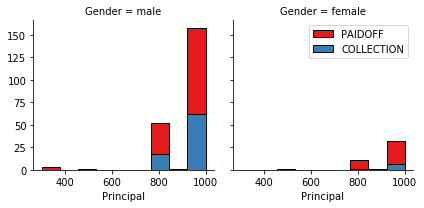

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

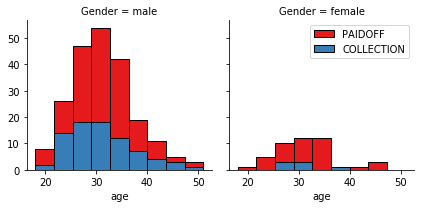

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

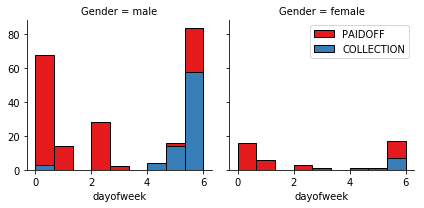

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=25)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [20]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
array=[]
for k in range(1,100):
    k_nn=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    k_nn.fit(X_train,y_train)
    k_nnpred=k_nn.predict(X_test)
    accuracy=metrics.accuracy_score(k_nnpred,y_test)
    array.append(accuracy)
    print (k,': ',accuracy*100)

1 :  69.23076923076923
2 :  65.38461538461539
3 :  71.15384615384616
4 :  64.42307692307693
5 :  69.23076923076923
6 :  69.23076923076923
7 :  71.15384615384616
8 :  70.1923076923077
9 :  70.1923076923077
10 :  70.1923076923077
11 :  71.15384615384616
12 :  69.23076923076923
13 :  67.3076923076923
14 :  69.23076923076923
15 :  68.26923076923077
16 :  66.34615384615384
17 :  68.26923076923077
18 :  67.3076923076923
19 :  67.3076923076923
20 :  67.3076923076923
21 :  67.3076923076923
22 :  66.34615384615384
23 :  67.3076923076923
24 :  68.26923076923077
25 :  72.11538461538461
26 :  71.15384615384616
27 :  72.11538461538461
28 :  72.11538461538461
29 :  73.07692307692307
30 :  73.07692307692307
31 :  73.07692307692307
32 :  72.11538461538461
33 :  72.11538461538461
34 :  72.11538461538461
35 :  74.03846153846155
36 :  74.03846153846155
37 :  74.03846153846155
38 :  74.03846153846155
39 :  74.03846153846155
40 :  75.0
41 :  74.03846153846155
42 :  74.03846153846155
43 :  74.03846153846155

In [21]:
print(array.index(max(array))+1,"-->",max(array)*100,'%')

40 --> 75.0 %


Text(0, 0.5, 'Train Accuracy')

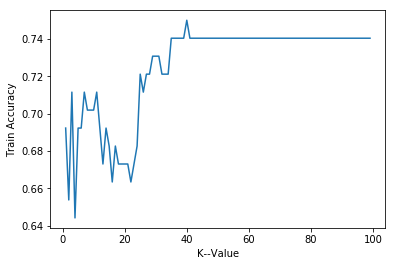

In [22]:
plt.plot(range(1,100),array)
plt.xlabel('K--Value')
plt.ylabel('Train Accuracy')

In [63]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
knn=KNeighborsClassifier(n_neighbors=40,weights='uniform')
knn.fit(X_train,y_train)
predKNN=knn.predict(X_test)
accuracy=metrics.accuracy_score(predKNN,y_test)
print(classification_report(y_test,predKNN))
print('J-SCORE : ',round(jaccard_similarity_score(y_test,predKNN)*100,2),'%')
print('F1-SCORE : ',f1_score(y_test,predKNN,average='weighted'))
print("accuracy : ",round(accuracy,3)*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.60      0.11      0.19        27
     PAIDOFF       0.76      0.97      0.85        77

   micro avg       0.75      0.75      0.75       104
   macro avg       0.68      0.54      0.52       104
weighted avg       0.72      0.75      0.68       104

J-SCORE :  75.0 %
F1-SCORE :  0.6796875
accuracy :  75.0 %


# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
deci_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
deci_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
!conda config --add channels conda-forge
!conda install pydotplus

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.11.27-0                   --> 2019.11.28-hecc5488_0 conda-forge
    certifi:         2019.11.28-py36_0   

In [29]:

!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python-graphviz-0.13.2     |             py_0          18 KB  conda-forge

The following NEW packages will be INSTALLED:

    python-graphviz: 0.13.2-py_0 conda-forge


python-graphviz-0.13 | 18 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


Accuracy:  0.7211538461538461


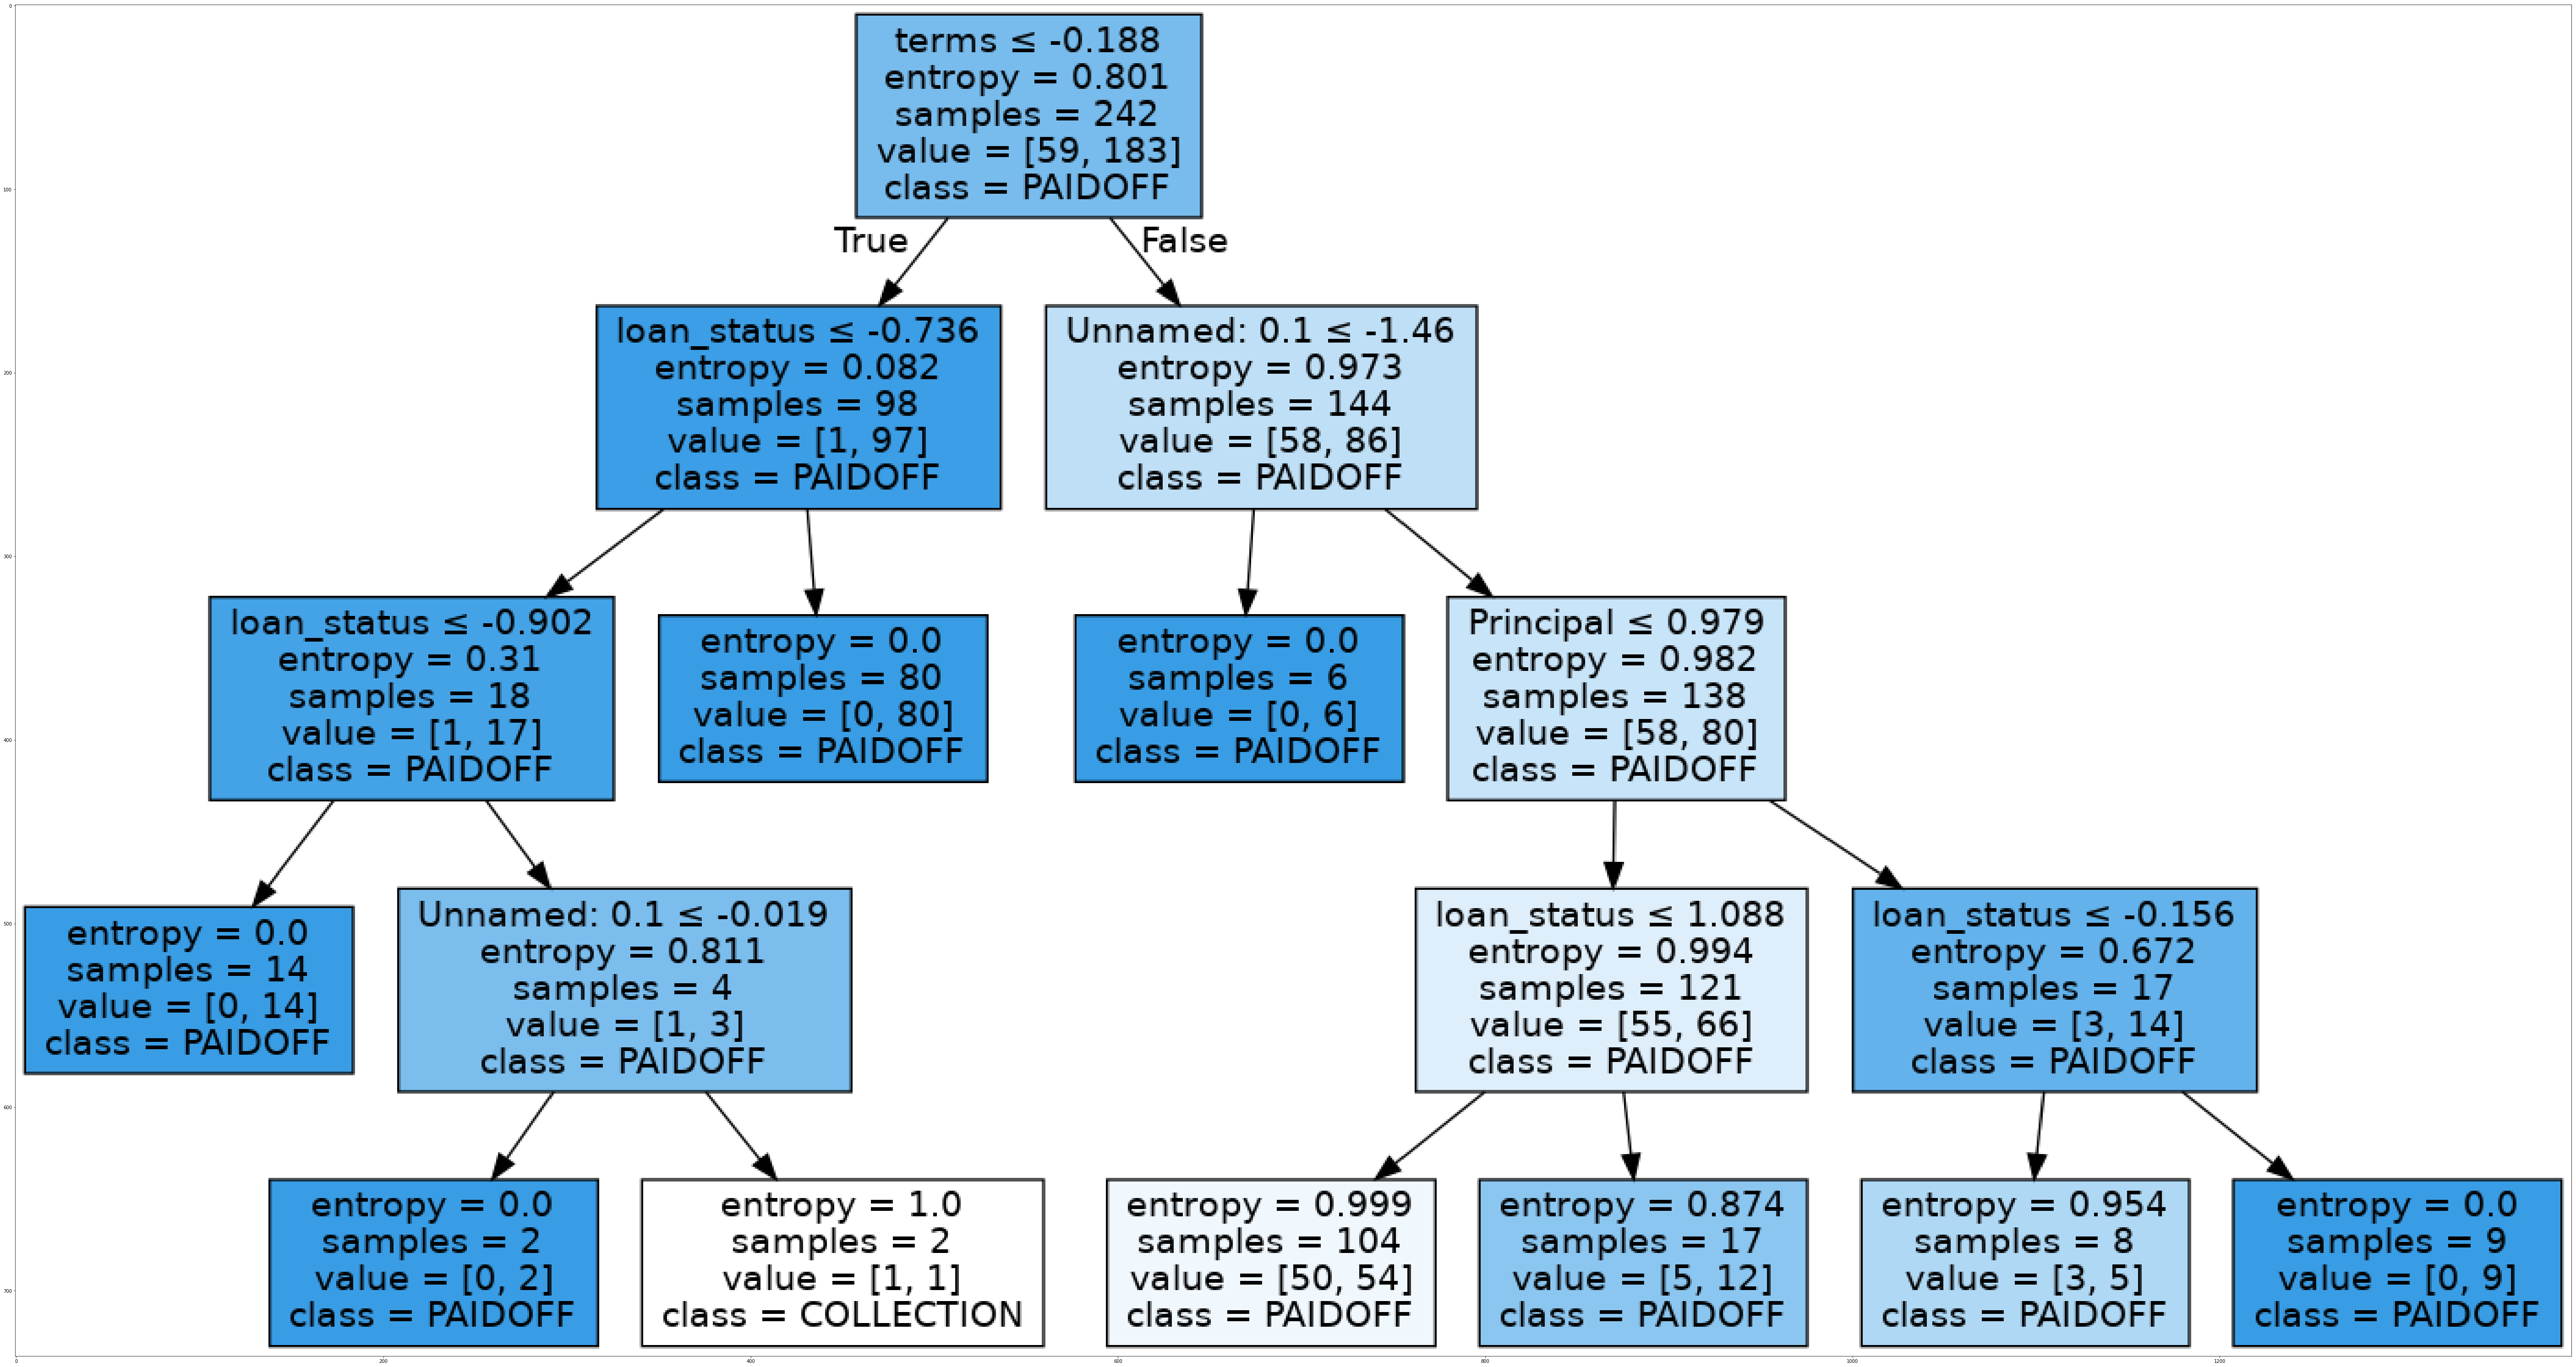

In [64]:
deci_tree_pred = deci_tree.predict(X_test)
print("Accuracy: ", metrics.accuracy_score(y_test, deci_tree_pred))
%matplotlib inline 
dot_data = StringIO()
filename = "loan.png"
labels = df.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
tree_new=tree.export_graphviz(deci_tree,feature_names=labels, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

In [35]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [36]:
from sklearn import svm
from sklearn.metrics import accuracy_score
Svm=svm.SVC(kernel='rbf').fit(X_train,y_train)
prediction_svm=Svm.predict(X_test)
accuracy_svm=accuracy_score(prediction_svm,y_test)
print(accuracy_svm*100)

68.26923076923077


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


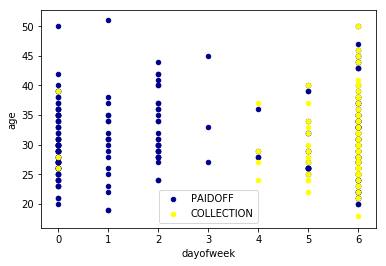

In [37]:
df_svm=df.copy()
df_svm['loan_status'] = df_svm['loan_status'].map({'PAIDOFF': 0, 'COLLECTION': 1})
ax = df_svm[df_svm['loan_status'] == 0][0:346].plot(kind='scatter', x='dayofweek', y='age', color='DarkBlue', label='PAIDOFF');
df_svm[df_svm['loan_status'] == 1][0:346].plot(kind='scatter', x='dayofweek', y='age', color='Yellow', label='COLLECTION', ax=ax);
plt.show()

In [62]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
print(classification_report(y_test,prediction_svm))
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(y_test,prediction_svm)*100,2),'%')
print('F1-SCORE : ',f1_score(y_test,prediction_svm,average='weighted'))
print("accuracy : ",accuracy_svm*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.29      0.15      0.20        27
     PAIDOFF       0.74      0.87      0.80        77

   micro avg       0.68      0.68      0.68       104
   macro avg       0.52      0.51      0.50       104
weighted avg       0.63      0.68      0.64       104

Jaccard Similarity Score :  68.27 %
F1-SCORE :  0.6447377290447248
accuracy :  68.26923076923077 %


In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.29      0.15      0.20        27
     PAIDOFF       0.74      0.87      0.80        77

   micro avg       0.68      0.68      0.68       104
   macro avg       0.52      0.51      0.50       104
weighted avg       0.63      0.68      0.64       104

Confusion matrix, without normalization
[[67 10]
 [23  4]]


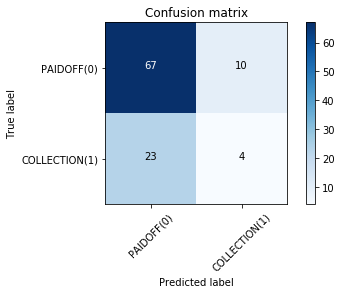

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_svm, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, prediction_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF(0)','COLLECTION(1)'],normalize= False,  title='Confusion matrix')

# Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression()
log_reg.fit(X_train,y_train)
prediction_log=log_reg.predict(X_test)
accuracy_logreg=accuracy_score(prediction_log,y_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [61]:
print(classification_report(y_test,prediction_log))
print('J-SCORE : ',round(jaccard_similarity_score(y_test,prediction_log)*100,2),'%')
print('F1-SCORE : ',f1_score(y_test,prediction_log,average='weighted'))
print("accuracy : ",accuracy_logreg*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.38      0.22      0.28        27
     PAIDOFF       0.76      0.87      0.81        77

   micro avg       0.70      0.70      0.70       104
   macro avg       0.57      0.55      0.55       104
weighted avg       0.66      0.70      0.67       104

J-SCORE :  70.19 %
F1-SCORE :  0.6737328562909959
accuracy :  70.1923076923077 %


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[ 6 21]
 [10 67]]
Confusion matrix, without normalization
[[ 6 21]
 [10 67]]


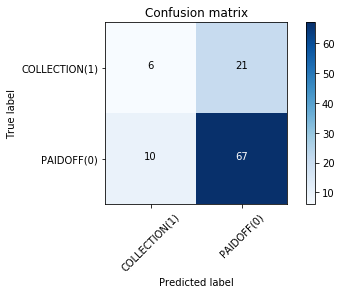

In [44]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_log, labels=['COLLECTION','PAIDOFF'])
print(cnf_matrix)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION(1)','PAIDOFF(0)'],normalize= False,  title='Confusion matrix')

# Model Evaluation using Test set

In [45]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [46]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-20 07:06:50--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-20 07:06:51 (247 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [47]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [48]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6


In [49]:
test_df['weekend']=test_df['dayofweek'].apply(lambda x: 1 if (x>3) else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
new=pd.get_dummies(test_df['education'])
test = test_df[['Principal','terms','age','Gender','weekend']]
test = pd.concat([test,new[['Bechalor','High School or Below','college']]], axis=1)
#test_feature.drop(['Master or Above'], axis = 1,inplace=True)
test.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [50]:
test_train= test.copy()
test_train= preprocessing.StandardScaler().fit(test_train).transform(test_train)
test_y=test_df['loan_status']

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [51]:
#K-NN   --->   IMPLEMENTATION  

In [52]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
array_test=[]
for k in range(1,100):
    k_nn_test=KNeighborsClassifier(n_neighbors=k,weights='uniform')
    k_nn_test.fit(X,y)
    k_nnpred_test=k_nn_test.predict(test_train)
    accuracy_test=metrics.accuracy_score(k_nnpred_test,test_y)
    array_test.append(accuracy_test)
    print (k,': ',accuracy_test*100)

1 :  70.37037037037037
2 :  57.407407407407405
3 :  64.81481481481481
4 :  62.96296296296296
5 :  74.07407407407408
6 :  68.51851851851852
7 :  72.22222222222221
8 :  70.37037037037037
9 :  70.37037037037037
10 :  68.51851851851852
11 :  68.51851851851852
12 :  66.66666666666666
13 :  70.37037037037037
14 :  70.37037037037037
15 :  72.22222222222221
16 :  70.37037037037037
17 :  72.22222222222221
18 :  70.37037037037037
19 :  72.22222222222221
20 :  74.07407407407408
21 :  75.92592592592592
22 :  75.92592592592592
23 :  75.92592592592592
24 :  72.22222222222221
25 :  74.07407407407408
26 :  77.77777777777779
27 :  75.92592592592592
28 :  77.77777777777779
29 :  75.92592592592592
30 :  77.77777777777779
31 :  74.07407407407408
32 :  79.62962962962963
33 :  77.77777777777779
34 :  79.62962962962963
35 :  79.62962962962963
36 :  77.77777777777779
37 :  79.62962962962963
38 :  79.62962962962963
39 :  79.62962962962963
40 :  79.62962962962963
41 :  79.62962962962963
42 :  79.62962962962963


In [53]:
print(array_test.index(max(array_test))+1,'-->',max(array_test))

32 --> 0.7962962962962963


In [54]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
knn_test=KNeighborsClassifier(n_neighbors=32,weights='uniform')
knn_test.fit(X,y)
knn_pred_test=knn_test.predict(test_train)
accuracy=metrics.accuracy_score(knn_pred_test,test_y)
print(classification_report(test_y,knn_pred_test))
print('J-SCORE : ',round(jaccard_similarity_score(test_y,knn_pred_test)*100,2),'%')
print('F1-SCORE : ',f1_score(test_y,knn_pred_test,average='weighted'))
print('ACCURACY : ',accuracy*100)

              precision    recall  f1-score   support

  COLLECTION       0.71      0.36      0.48        14
     PAIDOFF       0.81      0.95      0.87        40

   micro avg       0.80      0.80      0.80        54
   macro avg       0.76      0.65      0.67        54
weighted avg       0.78      0.80      0.77        54

J-SCORE :  79.63 %
F1-SCORE :  [0.48 0.87]
ACCURACY :  79.62962962962963


In [55]:
## DECISION TREES

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
deci_tree_test = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
deci_tree_test.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [60]:
deci_tree_pred_test=deci_tree_test.predict(test_train)
accuracy_deci_tree_pred_test=metrics.accuracy_score(deci_tree_pred_test,test_y)
print(classification_report(test_y,deci_tree_pred_test))
print('J-SCORE : ',round(jaccard_similarity_score(test_y,deci_tree_pred_test)*100,2),'%')
print('F1-SCORE : ',f1_score(test_y,deci_tree_pred_test,average='weighted'))
print('ACCURACY : ',accuracy*100)

              precision    recall  f1-score   support

  COLLECTION       0.75      0.21      0.33        14
     PAIDOFF       0.78      0.97      0.87        40

   micro avg       0.78      0.78      0.78        54
   macro avg       0.77      0.59      0.60        54
weighted avg       0.77      0.78      0.73        54

J-SCORE :  77.78 %
F1-SCORE :  0.7283950617283951
ACCURACY :  79.62962962962963


In [65]:
## SVM <--------

In [66]:
from sklearn import svm
from sklearn.metrics import accuracy_score
Svm_test=svm.SVC(kernel='rbf').fit(X,y)
prediction_svm_test=Svm_test.predict(test_train)
accuracy_svm_test=accuracy_score(prediction_svm_test,test_y)
print(accuracy_svm_test*100)

72.22222222222221


In [67]:
from sklearn.metrics import classification_report,jaccard_similarity_score,log_loss,f1_score
print(classification_report(test_y,prediction_svm_test))
print('Jaccard Similarity Score : ',round(jaccard_similarity_score(prediction_svm_test,test_y)*100,2),'%')
print('F1-SCORE : ',f1_score(prediction_svm_test,test_y,average='weighted'))
print("accuracy : ",accuracy_svm_test*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      0.97      0.84        40

   micro avg       0.72      0.72      0.72        54
   macro avg       0.37      0.49      0.42        54
weighted avg       0.55      0.72      0.62        54

Jaccard Similarity Score :  72.22 %
F1-SCORE :  0.8231780167264039
accuracy :  72.22222222222221 %


In [68]:
#  LOGISTIC REGRESSION

In [104]:
from sklearn.linear_model import LogisticRegression
log_reg_test=LogisticRegression()
log_reg_test.fit(X,y)
prediction_log_test=log_reg_test.predict(test_train)
accuracy_logreg_test=accuracy_score(prediction_log_test,test_y)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
print(classification_report(prediction_log_test,test_df_new_y))
print('J-SCORE : ',round(jaccard_similarity_score(prediction_log_test,test_df_new_y)*100,2),'%')
print('F1-SCORE : ',f1_score(prediction_log_test,test_df_new_y,average='weighted'))
print("accuracy : ",accuracy_logreg_test*100,'%')

              precision    recall  f1-score   support

  COLLECTION       0.07      1.00      0.13         1
     PAIDOFF       1.00      0.75      0.86        53

   micro avg       0.76      0.76      0.76        54
   macro avg       0.54      0.88      0.50        54
weighted avg       0.98      0.76      0.85        54

J-SCORE :  75.93 %
F1-SCORE :  0.8467542811628833
accuracy :  75.92592592592592 %


In [106]:
Algoritm=['KNN','DecisionTree','SVM','Logisticregression']
j_score_knn=jaccard_similarity_score(test_y,knn_pred_test)
j_score_deci=jaccard_similarity_score(y_test, deci_tree_pred)*100
j_score_svm=jaccard_similarity_score(prediction_svm_test,test_y)
j_score_logreg=jaccard_similarity_score(prediction_log_test,test_y)
J_SCORE=[j_score_knn,j_score_deci,j_score_svm,j_score_logreg]
f1score_knn=f1_score(test_y,knn_pred_test,average='weighted')
f1score_deci_tree=f1_score(y_test, deci_tree_pred,average='weighted')
f1score_svm=f1_score(prediction_svm_test,test_y,average='weighted')
f1score_logreg=f1_score(prediction_log_test,test_y,average='weighted')
F1_SCORE=[f1score_knn,f1score_deci_tree,f1score_svm,f1score_logreg]
Logloss = log_loss(prediction_log_test,test_y)
print("LogLoss: ", Logloss)

In [107]:
table = pd.DataFrame({
    "Algorithm": Algoritm,
    "Jaccatd": J_SCORE,
    "F1-Score": F1_SCORE,
    "LogLoss":[np.NAN,np.NAN,np.NAN,56.770321]})
table

,Algorithm,Jaccatd,F1-Score,LogLoss
0,KNN,0.796296,0.770541,NaN
1,DecisionTree,72.115385,0.620434,NaN
2,SVM,0.722222,0.823178,NaN
3,Logisticregression,0.759259,0.846754,56.770321


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>